# Obesity project

## 1) Importation and cleaning

In [139]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso,SGDRegressor,LogisticRegression
from sklearn import svm,tree
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler

In [140]:
warnings.filterwarnings('ignore')

In [179]:
df=pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [180]:
df=df.rename(columns = {"family_history_with_overweight": "genetic",
                          "FAVC": "high_calorific",
                          "FCVC": "vegetable",
                          "NCP": "frequence_meal",
                          "CAEC": "between_meal",
                          "CH2O": "water",
                          "SCC": "calories_monitoring",
                          "FAF": "physical_activity",
                          "TUE": "technology_time",
                          "CALC": "alcohol",
                          "MTRANS": "transportation",
                          "NObeyesdad": "obesity",
                          "SMOKE":"smoke",  
                         })

We apply the normal encoding on the columns that have 2 possible values

In [181]:
y=df.obesity  # target
df=df.drop('obesity',axis=1)

In [182]:
df.head()

,Gender,Age,Height,Weight,genetic,high_calorific,vegetable,frequence_meal,between_meal,smoke,water,calories_monitoring,physical_activity,technology_time,alcohol,transportation
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


Here we choose to apply the one-hot encoding on the 3 columns that have more than 2 possible values

In [183]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from  sklearn.compose import make_column_transformer

#OneHotEncoder et Scaling 

In [184]:
transformer = make_column_transformer(
        (OneHotEncoder(), ["between_meal","alcohol","transportation"]),
        (OrdinalEncoder(), ["Gender","genetic","high_calorific","smoke","calories_monitoring"]),
        remainder=StandardScaler())
transformed = transformer.fit_transform(df)

#Creation du dataframe avec recuperation des noms des colonnes
df=pd.DataFrame(transformed, columns=list(map(lambda x:x.split("__")[1],transformer.get_feature_names_out())))

In [185]:
df

,between_meal_Always,between_meal_Frequently,between_meal_Sometimes,between_meal_no,alcohol_Always,alcohol_Frequently,alcohol_Sometimes,alcohol_no,transportation_Automobile,transportation_Bike,...,smoke,calories_monitoring,Age,Height,Weight,vegetable,frequence_meal,water,physical_activity,technology_time
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.525774,0.097045,1.711763,1.088342,0.404153,-0.456705,0.783135,0.407996
2107,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.367195,0.502844,1.800914,1.088342,0.404153,-0.004702,0.389341,-0.096251
2108,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.281909,0.541672,1.798868,1.088342,0.404153,0.075361,0.474971,-0.019018
2109,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.007776,0.404927,1.785780,1.088342,0.404153,1.377801,0.151471,-0.117991


In [186]:
df.head()


,between_meal_Always,between_meal_Frequently,between_meal_Sometimes,between_meal_no,alcohol_Always,alcohol_Frequently,alcohol_Sometimes,alcohol_no,transportation_Automobile,transportation_Bike,...,smoke,calories_monitoring,Age,Height,Weight,vegetable,frequence_meal,water,physical_activity,technology_time
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [187]:
df.columns

Index(['between_meal_Always', 'between_meal_Frequently',
       'between_meal_Sometimes', 'between_meal_no', 'alcohol_Always',
       'alcohol_Frequently', 'alcohol_Sometimes', 'alcohol_no',
       'transportation_Automobile', 'transportation_Bike',
       'transportation_Motorbike', 'transportation_Public_Transportation',
       'transportation_Walking', 'Gender', 'genetic', 'high_calorific',
       'smoke', 'calories_monitoring', 'Age', 'Height', 'Weight', 'vegetable',
       'frequence_meal', 'water', 'physical_activity', 'technology_time'],
      dtype='object')

We normalize the data

## 2) Implementation of the models

### Train-test split

In [188]:
from sklearn.model_selection import train_test_split

X=df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

### First model

First we choose to apply a random forest model to the data, keeping all the features and columns

In [204]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=5)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


In [205]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8675078864353313


### Comparison of the models

We try several models and compare them to see which one gets the best accuracy

In [84]:
def Test_algo_Obesity(models, labels,train_x,test_x,train_y,test_y):
    dict_train_score={}
    dict_test_score={}
    for k in range(len(models)):
        model=models[k]
        model.fit(train_x,train_y)
        dict_train_score[labels[k]]=model.score(train_x,train_y)
        dict_test_score[labels[k]]=model.score(test_x,test_y)
        print("Test {} score ={: 0.3f}".format(labels[k],dict_test_score[labels[k]]))
    print("\nbest Model for Obesity dataset is {} with test score :{: 0.3f}".format(max(dict_test_score, key=dict_test_score.get),dict_test_score[max(dict_test_score, key=dict_test_score.get)]))
    return max(dict_test_score, key=dict_test_score.get)

In [85]:
models_liste=[svm.SVC(),tree.DecisionTreeClassifier(),RandomForestClassifier(n_estimators=500),KNeighborsClassifier(),LogisticRegression()]
labels_liste=["SVM","Desicion tree","RandomForest","KNeighbors","LogisticRegression"]

In [127]:
Test_algo_Obesity(models_liste, labels_liste,X_train, X_test, y_train, y_test)

Test SVM score = 0.924
Test Desicion tree score = 0.943
Test RandomForest score = 0.942
Test KNeighbors score = 0.822
Test LogisticRegression score = 0.890

best Model for Obesity dataset is Desicion tree with test score : 0.943


'Desicion tree'

### Features importance

Now let's see the importance of the different features on the model

In [128]:
import numpy as np

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [129]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

In [130]:
import matplotlib.pyplot as plt

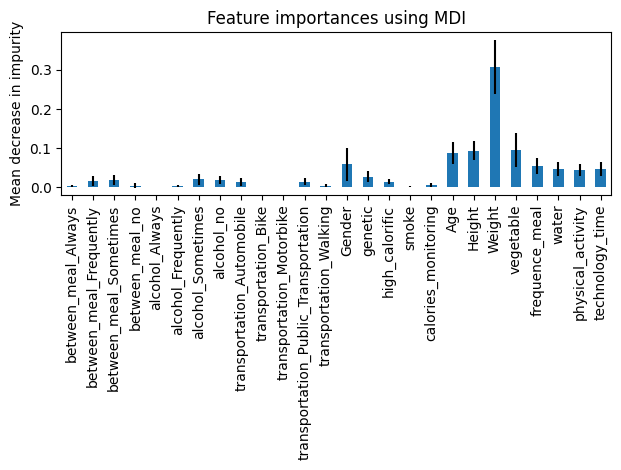

In [131]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that smoke, calories_monitoring have almost no impact, that's why we will remove them : thus, we can ask fewer questions to the sample.

Let's remove these columns and analyze the results

In [133]:
from sklearn.model_selection import train_test_split

X=df.drop(['smoke',"calories_monitoring"],axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [134]:
Test_algo_Obesity(models_liste, labels_liste,X_train, X_test, y_train, y_test)

Test SVM score = 0.918
Test Desicion tree score = 0.918
Test RandomForest score = 0.953
Test KNeighbors score = 0.812
Test LogisticRegression score = 0.893

best Model for Obesity dataset is RandomForest with test score : 0.953


'RandomForest'

We see that by removing these 2 columns, we even get a better accuracy

### Grid search

We try the random forest model (the best so far) with different hyperparameters and see which ones are the best

In [193]:
param_grid={"max_depth":[k for k in range(5)]+[None],"n_estimators":[k for k in range(500,501)],"criterion":["gini","entropy","log_loss"]}
grid=GridSearchCV(RandomForestClassifier(),param_grid)
grid.fit(X_train,y_train)
print('grid params best model',grid.best_params_)
print('grid score best model',grid.best_score_)
best_model=grid.best_estimator_
print('test score best model', best_model.score(X_test,y_test))

grid params best model {'criterion': 'log_loss', 'max_depth': None, 'n_estimators': 500}
grid score best model 0.9410948236371965
test score best model 0.944794952681388
